# Sam optimizer
In [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://arxiv.org/abs/2010.01412) the authors propose a new optimization technique, SAM. SAM is not satisfied with just a low loss, instead it seeks a neighbourhood with uniformly low loss. This is well visualised by the figure below. SAM is motivated by the link between the geometry of the loss landscape and generalisation. It makes sense that a low loss within a uniformly low loss neighbourhood will generalise better than a low loss within a region of higher variance.

<br>I found the paper to be very interresting. This unoffical GitHub [repository](https://github.com/davda54/sam/tree/cdcbdc1574022d3a3c3240da136378c38562d51d) implements SAM in PyTorch, so I decided to try it out. Lets see if SAM is able to improve the accuracy of a simple CNN on the MNIST dataset.

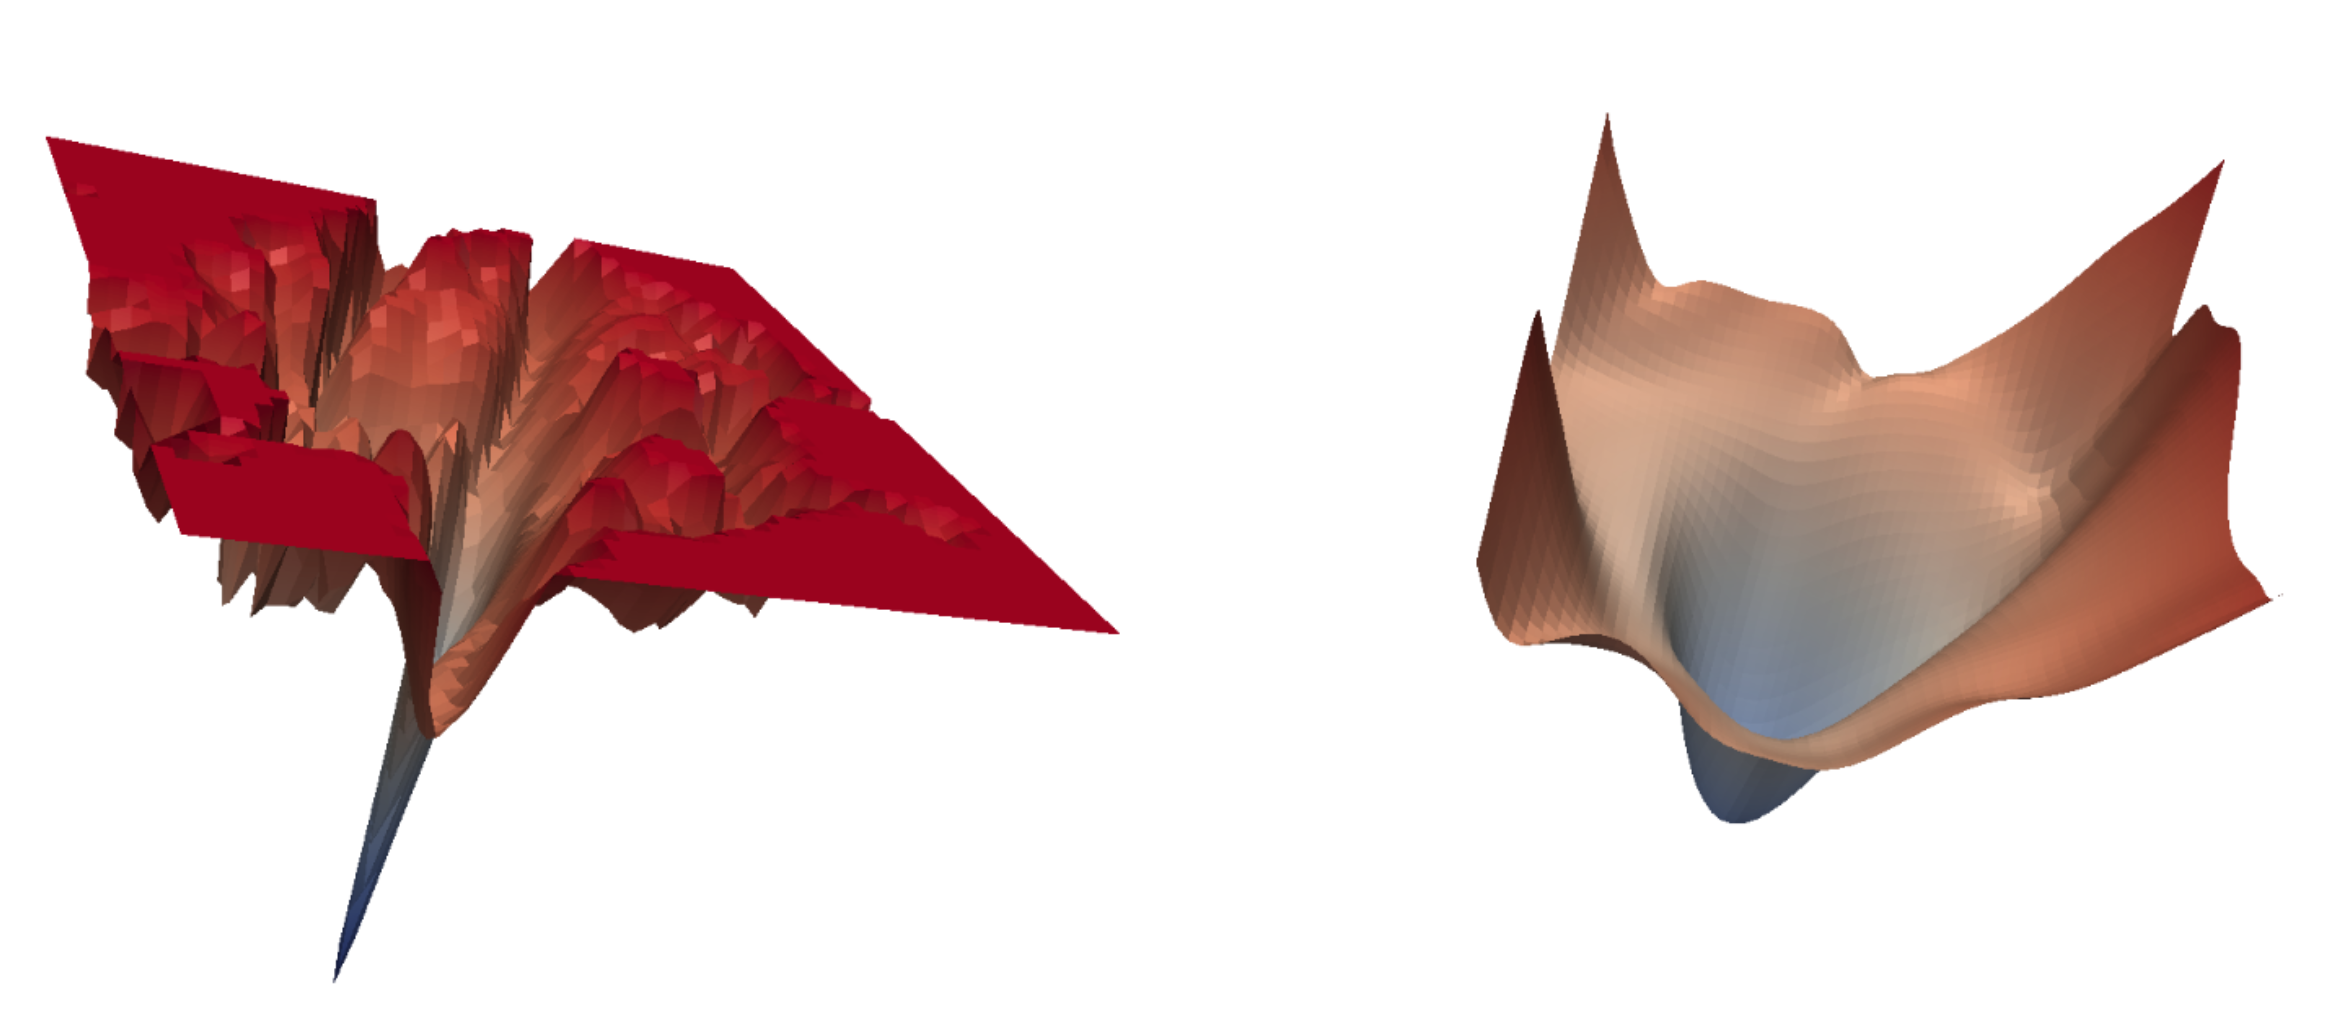

ResNet loss landscape at the end of training with and without SAM. Sharpness-aware updates lead to a significantly wider minimum, which then leads to better generalization properties.

## Imports

In [64]:
import torch
from torch import nn
from torch.nn.functional import cross_entropy
from torch.utils.data import random_split
from torchvision import datasets, transforms
!git clone https://github.com/davda54/sam.git
from sam.sam import SAM

## MNIST
I will use the MNIST dataset for my experiment

In [97]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

## CNN
I implement a simple CNN.
<br>I will not use batch normalization as this can cause some problems with SAM.

In [98]:
def init_model():
    return nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256, 10)
        ).to("cuda")

## Hyperparameters

In [99]:
max_epochs = 100
callback = 5

## Functions

In [100]:
def evaluate(model, data_loader):
        #Evaluate on the validation set
        correct = 0
        total = 0
        model.eval()
        for img, label in data_loader:
            img, label = img.to("cuda"), label.to("cuda")
            output = model(img)

            #Track accuracy
            correct += sum(torch.argmax(output, dim=-1) == label)
            total += label.shape[0]

        return float(correct/total)

In [109]:
def train_model(model, optimize):
    epoch = 0
    best_acc = 0
    not_increased = 0
    while epoch < max_epochs and not_increased < callback:
        #Train on the training set
        model.train()
        for img, label in train_loader:
            img, label = img.to("cuda"), label.to("cuda")
            optimize(model, img, label)

        #Evaluate on the validation set
        acc = evaluate(model, val_loader)
        if acc > best_acc:
            best_acc = acc
            not_increased = 0
        else:
            not_increased += 1

        print(f"Epoch {epoch} with {round(acc, 3)} accuracy on the validation set.")
        epoch += 1

## Model trained without SAM
Let us first train the model with just SGD. <br> I will train using a callback function based on the validation accuracy.

In [102]:
model = init_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [103]:
def optimize_sgd(model, img, label):
    optimizer.zero_grad()
    output = model(img)
    loss = cross_entropy(output, label)
    loss.backward()
    optimizer.step()

In [104]:
train_model(model, optimize_sgd)

Epoch 0 with 0.109 accuracy on the validation set.
Epoch 1 with 0.807 accuracy on the validation set.
Epoch 2 with 0.931 accuracy on the validation set.
Epoch 3 with 0.956 accuracy on the validation set.
Epoch 4 with 0.965 accuracy on the validation set.
Epoch 5 with 0.971 accuracy on the validation set.
Epoch 6 with 0.975 accuracy on the validation set.
Epoch 7 with 0.977 accuracy on the validation set.
Epoch 8 with 0.978 accuracy on the validation set.
Epoch 9 with 0.978 accuracy on the validation set.
Epoch 10 with 0.979 accuracy on the validation set.
Epoch 11 with 0.979 accuracy on the validation set.
Epoch 12 with 0.98 accuracy on the validation set.
Epoch 13 with 0.981 accuracy on the validation set.
Epoch 14 with 0.98 accuracy on the validation set.
Epoch 15 with 0.98 accuracy on the validation set.
Epoch 16 with 0.981 accuracy on the validation set.
Epoch 17 with 0.981 accuracy on the validation set.
Epoch 18 with 0.981 accuracy on the validation set.
Epoch 19 with 0.981 accur

### Evaluate model
I will evaluate the model on the test set

In [105]:
acc = evaluate(model, test_loader)
print(f"Accuracy of {round(acc, 4)} on the test set.")

Accuracy of 0.9813 on the test set.


## Model trained with SAM
Now I will train the same model using the SAM optimizer

In [110]:
model = init_model()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.01)

In [111]:
def optimize_sam(model, img, label):
    output = model(img)

    #First forward-backward pass
    loss = cross_entropy(output, label)
    loss.backward()
    optimizer.first_step(zero_grad=True)

    #First forward-backward pass
    loss = cross_entropy(model(img), label)
    loss.backward()
    optimizer.second_step(zero_grad=True)

In [112]:
train_model(model, optimize_sam)

Epoch 0 with 0.109 accuracy on the validation set.
Epoch 1 with 0.109 accuracy on the validation set.
Epoch 2 with 0.871 accuracy on the validation set.
Epoch 3 with 0.938 accuracy on the validation set.
Epoch 4 with 0.956 accuracy on the validation set.
Epoch 5 with 0.964 accuracy on the validation set.
Epoch 6 with 0.97 accuracy on the validation set.
Epoch 7 with 0.973 accuracy on the validation set.
Epoch 8 with 0.975 accuracy on the validation set.
Epoch 9 with 0.978 accuracy on the validation set.
Epoch 10 with 0.98 accuracy on the validation set.
Epoch 11 with 0.981 accuracy on the validation set.
Epoch 12 with 0.982 accuracy on the validation set.
Epoch 13 with 0.982 accuracy on the validation set.
Epoch 14 with 0.983 accuracy on the validation set.
Epoch 15 with 0.984 accuracy on the validation set.
Epoch 16 with 0.984 accuracy on the validation set.
Epoch 17 with 0.985 accuracy on the validation set.
Epoch 18 with 0.985 accuracy on the validation set.
Epoch 19 with 0.985 accu

### Evaluate model
I will evaluate the model on the test set

In [113]:
acc = evaluate(model, test_loader)
print(f"Accuracy of {round(acc, 4)} on the test set.")

Accuracy of 0.9892 on the test set.


The test set error rate is almost halved when trained using the SAM optimizer. These results are better than the experiments from the [repository](https://github.com/davda54/sam/tree/cdcbdc1574022d3a3c3240da136378c38562d51d). The SAM optimizer did train for more epochs though. I am sure the training without SAM could be improved to close the gap.